In [1]:
import numpy as np

In [2]:
from os import listdir
from pandas import read_csv

path = '../posts_utf8/'
filenames = listdir(path)
posts_data = read_csv('./risk/posts_data.csv')

In [3]:
from tqdm import tqdm
import nltk
import string

def process_texts(filenames, analyzer):
    normalized = np.array([])
    print('normalizing')
    for name in  tqdm(filenames):
        with open(path + name, 'r', encoding='utf8') as f:
            tokens = nltk.word_tokenize(f.read().lower(), 'russian')
            normalized = np.append(normalized, [analyzer.normal_forms(word)[0] for word in tokens 
                           if word not in string.punctuation + '«»–``\'\''])
    print('counting')
    f_dict = {}
    for word in tqdm(set(normalized)):
        f_dict[word] = np.sum(normalized == word)
    print('sorting')
    return dict(sorted(f_dict.items(), key=lambda x: x[1], reverse=True))

In [4]:
authors = set(posts_data['author'])

In [5]:
authors_text_count = {author: len(posts_data[posts_data['author'] == author]) for author in authors}
authors_text_count = dict(sorted(authors_text_count.items(), key=lambda x: x[1], reverse=True))

In [6]:
author_to_text_len = {author: 0 for author in authors}
for index, row in tqdm(posts_data.iterrows()):
    if row['ID'] in filenames:
        with open(path + row['ID'], 'r', encoding='utf8') as f:
            author_to_text_len[row['author']] += len(f.read())
author_to_text_len = dict(sorted(author_to_text_len.items(), key=lambda x: x[1], reverse=True))

33863it [04:23, 128.72it/s]


In [7]:
from sklearn.metrics import mean_squared_error

def mse(Y):
    y = Y
    X = np.arange(1, len(Y)+1)
    power_to_mse = dict()
    for power in np.arange(0.1, 5, 0.2):
        x = 1 / X ** power
        b = (np.average(x * y) - np.average(x)*np.average(y)) / (np.average(x**2) - np.average(x)**2)
        a = np.average(y) - np.average(x)*b
        power_to_mse[power] = mean_squared_error(y, a + b * x)
    power_to_mse = sorted(power_to_mse.items(), key=lambda x: x[1])
    return a, b, power_to_mse[0][0]

In [8]:
from pymorphy2 import MorphAnalyzer
from matplotlib import pyplot as plt

def zipf_plot(f_dict):
    X = np.arange(1, len(f_dict) + 1)
    Y = list(f_dict.values())
    plt.xlim(0, 200)
    plt.ylim(0, 1000)
    a, b, p = mse(Y)
    plt.plot(X,  b / X**p + a, 'r')
    plt.plot(X, Y, 'g')
    plt.title('автор: ' + author)
    plt.xlabel('порядковый номер')
    plt.ylabel('количество употреблений')
    plt.show()
    print('a = ', a)
    print('b = ', b)
    print('p = ', p)

### Проверка закона Ципфа

Считаем, что зависимость имеет вид $ y = a + \frac{b}{x^p} $, где $x$ - порядковый номер слова в частотном словаре, $y$ - частота употреблнения слова

normalizing


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:37<00:00,  6.20it/s]


counting


100%|███████████████████████████████████████████████████████████████████████████| 10967/10967 [00:35<00:00, 306.39it/s]


sorting


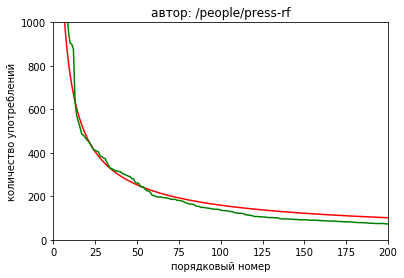

a =  9.033751642236481
b =  3769.417542956541
p =  0.7000000000000001
количество статей:  238
размер словаря:  10967


In [14]:
author = list(author_to_text_len.items())[10][0]
f_dict = process_texts(list(posts_data[posts_data['author'] == author]['ID']), MorphAnalyzer())
zipf_plot(f_dict)
print('количество статей: ', authors_text_count[author])
print('размер словаря: ', len(f_dict))

normalizing


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:13<00:00,  6.65it/s]


counting


100%|████████████████████████████████████████████████████████████████████████████| 6940/6940 [00:05<00:00, 1245.10it/s]


sorting


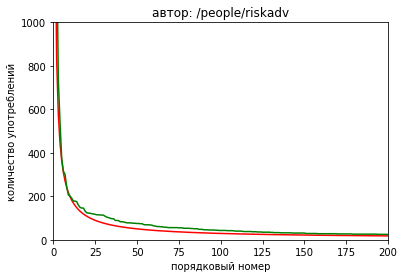

a =  4.9493850995727025
b =  1531.1624750458386
p =  0.9000000000000001
количество статей:  88
размер словаря:  6940


In [15]:
author = list(author_to_text_len.items())[50][0]
f_dict = process_texts(list(posts_data[posts_data['author'] == author]['ID']), MorphAnalyzer())
zipf_plot(f_dict)
print('количество статей: ', authors_text_count[author])
print('размер словаря: ', len(f_dict))

normalizing


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:04<00:00, 15.59it/s]


counting


100%|████████████████████████████████████████████████████████████████████████████| 3167/3167 [00:00<00:00, 4750.69it/s]


sorting


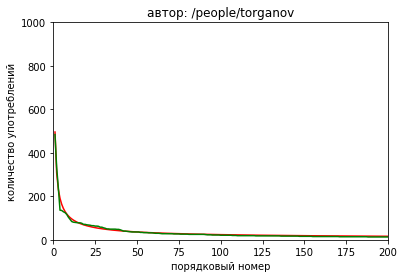

a =  4.183404400491088
b =  491.54202849062796
p =  0.7000000000000001
количество статей:  74
размер словаря:  3167


In [16]:
author = list(author_to_text_len.items())[150][0]
f_dict = process_texts(list(posts_data[posts_data['author'] == author]['ID']), MorphAnalyzer())
zipf_plot(f_dict)
print('количество статей: ', authors_text_count[author])
print('размер словаря: ', len(f_dict))

### Биграммы

In [7]:
def count_bigrams(filenames):
    bigrams_count = {}
    for name in tqdm(filenames):
        with open(path + name,'r', encoding='utf8') as f:
            tokens = nltk.word_tokenize(f.read().lower(), 'russian')
            for bigram in zip(tokens[:-1], tokens[1:]):
                if bigram in bigrams_count.keys():
                    bigrams_count[bigram] += 1
                else:
                    bigrams_count[bigram] = 1
    return dict(sorted(bigrams_count.items(), key=lambda x: x[1], reverse=True))

In [8]:
def count_words(filenames):
    tokens_count = {}
    for name in tqdm(filenames):
        with open(path + name, 'r', encoding='utf8') as f:
            tokens = nltk.word_tokenize(f.read().lower(), 'russian')
            for token in tokens:
                tokens_count[token] = tokens_count[token] + 1 if token in tokens_count.keys() else 1
    return dict(sorted(tokens_count.items(), key=lambda x: x[1], reverse=True))

In [9]:
from nltk.corpus import stopwords

# считаем частоту употребления для самого болтливого автора
author = list(author_to_text_len.items())[0][0]
count = count_bigrams(list(posts_data[posts_data['author'] == author]['ID']))
count = {bigram: count[bigram] for bigram in count.keys() 
         if bigram[0] not in string.punctuation + '»–\'\'' 
         and bigram[1] not in string.punctuation + '»–\'\''}

100%|█████████████████████████████████████████████████████████████████████████████| 2533/2533 [00:17<00:00, 144.98it/s]


In [9]:
list(count.items())[:25]

[(('в', 'этом'), 1117),
 (('у', 'нас'), 1006),
 (('и', 'в'), 888),
 (('так', 'что'), 877),
 (('и', 'не'), 781),
 (('потому', 'что'), 651),
 (('у', 'меня'), 626),
 (('я', 'не'), 599),
 (('не', 'было'), 563),
 (('этом', 'году'), 543),
 (('так', 'как'), 521),
 (('на', 'вершину'), 517),
 (('в', 'том'), 516),
 (('о', 'том'), 436),
 (('что', 'в'), 436),
 (('и', 'на'), 430),
 (('и', 'я'), 427),
 (('во', 'время'), 426),
 (('что', 'я'), 414),
 (('а', 'также'), 399),
 (('для', 'меня'), 389),
 (('не', 'только'), 382),
 (('это', 'не'), 380),
 (('что', 'это'), 377),
 (('и', 'мы'), 359)]

In [10]:
# пытаемся увидеть что-то содержательное путем удаления стопслов
count_without_stopwords = {bigram: count[bigram] for bigram in count.keys() 
         if bigram[0] not in stopwords.words('russian') 
         and bigram[0] not in stopwords.words('russian')
        }

In [11]:
list(count_without_stopwords.items())[:25]

[(('это', 'не'), 380),
 (('--', '--'), 312),
 (('это', 'было'), 295),
 (('вверх', 'по'), 290),
 (('вместе', 'с'), 245),
 (('выход', 'на'), 237),
 (('несмотря', 'на'), 230),
 (('прошлом', 'году'), 213),
 (('восхождение', 'на'), 208),
 (('восхождения', 'на'), 205),
 (('следующий', 'день'), 196),
 (('базовый', 'лагерь'), 189),
 (('выйти', 'на'), 183),
 (('это', 'был'), 175),
 (('сих', 'пор'), 173),
 (('никто', 'не'), 172),
 (('самом', 'деле'), 164),
 (('очень', 'много'), 149),
 (('кубка', 'мира'), 149),
 (('станция', 'на'), 145),
 (('внутреннему', 'углу'), 142),
 (('кроме', 'того'), 140),
 (('внутренний', 'угол'), 138),
 (('это', 'очень'), 137),
 (('тому', 'же'), 135)]

### Dice

In [10]:
def dice(bigrams_count, words_count):
    bigrams_dice = {}
    for (w1, w2) in bigrams_count.keys():
        bigrams_dice[(w1, w2)] = 2 * bigrams_count[(w1, w2)] / (words_count[w1] + words_count[w2])
    return dict(sorted(bigrams_dice.items(), key=lambda x : x[1], reverse=True))

In [11]:
#author = list(author_to_text_len.items())[0][0]
files = [name for name in posts_data['ID'] if name in filenames]
bigrams = count_bigrams(files)
words = count_words(files)
bigrams_dice = dice(bigrams, words)

100%|███████████████████████████████████████████████████████████████████████████| 33859/33859 [03:38<00:00, 154.61it/s]


In [12]:
sorted([(item[0], item[1], bigrams[item[0]]) for item in bigrams_dice.items() if item[1] == 1.0], key=lambda x: bigrams[x[0]], reverse=True)[:40]

[(('shauna', 'coxsey'), 1.0, 52),
 (('miho', 'nonaka'), 1.0, 33),
 (('ifmga/', 'uiagm/'), 1.0, 15),
 (('кеичиро', 'коренага'), 1.0, 14),
 (('ama', 'dablam'), 1.0, 13),
 (('glairon', 'mondet'), 1.0, 12),
 (('heiko', 'wilhelm'), 1.0, 12),
 (('м.т.______________', 'e-mail____________'), 1.0, 12),
 (('нангпай', 'госум'), 1.0, 10),
 (('ариес', 'сусанти'), 1.0, 10),
 (('rote', 'fluh'), 1.0, 10),
 (('settings\\apk\\мои', 'документы\\'), 1.0, 10),
 (('kenzo', 'okawa'), 1.0, 10),
 (('juliane', 'wurm'), 1.0, 9),
 (('дарины', 'беляевской'), 1.0, 9),
 (('ruff', 'tuff'), 1.0, 9),
 (('юргис', 'кайрис'), 1.0, 9),
 (('density', 'intuition®'), 1.0, 9),
 (('людовико', 'фоссали'), 1.0, 8),
 (('пеньи', 'гуара'), 1.0, 8),
 (('elma', 'fleuret'), 1.0, 8),
 (('sandra', 'lettner'), 1.0, 8),
 (('pierra', 'menta'), 1.0, 7),
 (('kush', 'khashah'), 1.0, 7),
 (('aurelia', 'sarisson'), 1.0, 7),
 (('franziska', 'sterrer'), 1.0, 7),
 (('nika', 'potapova'), 1.0, 7),
 (('photohub', 'manometr'), 1.0, 7),
 (('трансгаз', '

в большой список имен и фамилий затесался трансгаз югорск :)

### Mutual information

In [17]:
from math import log
def mutual_information(bigrams, words):
    mutual_info = {}
    for (w1, w2) in bigrams.keys():
        mutual_info[(w1, w2)] =  log(bigrams[(w1, w2)] / (words[w1] * words[w2]))
    return dict(sorted(mutual_info.items(), key=lambda x : x[1], reverse=True))

In [18]:
info = mutual_information(bigrams, words)

In [31]:
{item: (info[item], bigrams[item]) for item in list(info.keys())[:50]}

{('3616', '2515'): (0.0, 1),
 ('аскари', 'авиатион'): (0.0, 1),
 ('сорокаградусными', 'морозцами'): (0.0, 1),
 ('7601', '0026'): (0.0, 1),
 ('0026', '0532'): (0.0, 1),
 ('ярлыкам', 'интернациональна'): (0.0, 1),
 ('08/8', '02/8'): (0.0, 1),
 ('автопилотам', 'зуров'): (0.0, 1),
 ('гларо', 'ропаза'): (0.0, 1),
 ('противовоспалительную', 'мазь/гель'): (0.0, 1),
 ('закалённой', 'лопаткой-язычком'): (0.0, 1),
 ('2102', '1296'): (0.0, 1),
 ('бенджамин', 'гугонне'): (0.0, 1),
 ('fenris', 'kjeften'): (0.0, 1),
 ('томаше', 'мацкевиче'): (0.0, 1),
 ('ледимир', 'безносов.днике'): (0.0, 1),
 ('окно…не', 'помню…провалился'): (0.0, 1),
 ('39.454557', '72.957681'): (0.0, 1),
 ('39.459302', '72.939858'): (0.0, 1),
 ('39.459503', '72.952499'): (0.0, 1),
 ('резюмировались', 'утверждениями'): (0.0, 1),
 ('слодкевич', 'ua3ahm'): (0.0, 1),
 ('полночным', 'песнопеньям'): (0.0, 1),
 ('добродушия', 'нежадного'): (0.0, 1),
 ('благоухающему', 'рассыпчатому'): (0.0, 1),
 ('нервишки…очень', 'крутой…бдительность')

### t-score

In [33]:
from math import sqrt

def t_score(bigrams, words):
    scores = {}
    N = sum(words.values())
    for (w1, w2) in bigrams.keys():
        scores[' '.join([w1, w2])] = (bigrams[(w1, w2)] - words[w1] * words[w2] / N) / sqrt(bigrams[(w1, w2)]) 
    return dict(sorted(scores.items(), key=lambda x : x[1], reverse=True))

In [36]:
bigrams = {bigram: bigrams[bigram] for bigram in bigrams.keys() 
         if bigram[0] not in string.punctuation + '»–\'\'' 
         and bigram[1] not in string.punctuation + '»–\'\''}
t_scores = t_score(bigrams, words)

In [38]:
list(t_scores.items())[:50]

[('-- --', 103.81245998486062),
 ('у нас', 92.34268921002166),
 ('в этом', 89.33297993458379),
 ('у меня', 81.94626891032715),
 ('не было', 75.79556682069988),
 ('в горах', 71.00938907572811),
 ('потому что', 68.57447484148884),
 ('так как', 66.99435730970448),
 ('в том', 65.10326249130935),
 ('во время', 64.89829005565433),
 ('на вершину', 63.12118320614634),
 ('так что', 63.08508948430357),
 ('а также', 62.92390163270978),
 ('я не', 61.99050417421519),
 ('не только', 60.21108841293755),
 ('этом году', 60.1622515161887),
 ('так же', 59.422880073993234),
 ('о том', 57.349130512581254),
 ('так и', 56.314934009371974),
 ('на высоте', 56.25331100511347),
 ('один из', 55.542799608342456),
 ('в этот', 55.38200694623952),
 ('при этом', 55.35002985208007),
 ('... ...', 54.00460895691325),
 ('в общем', 53.978777569737616),
 ('да и', 53.930319344722754),
 ('и не', 53.291704264978314),
 ('может быть', 53.087145090820854),
 ('red fox', 52.88538207345741),
 ('для меня', 52.12741939480355),
 ('что 

Рисковчане любят горы и red fox :)